# Image Classification using VGG16

Prepare the environment

In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Kaggle"

In [2]:
%cd /content/drive/My Drive/Kaggle

/content/drive/My Drive/Kaggle


Download dataset

In [3]:
!kaggle datasets download -d alessiocorrado99/animals10 --force

 98% 571M/586M [00:09<00:00, 52.2MB/s]
100% 586M/586M [00:09<00:00, 62.3MB/s]


Unzip dataset

In [4]:
!unzip \*.zip -d "/content/drive/My Drive/Kaggle" && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/My Drive/Kaggle/raw-img/ragno/OIP-MVdIFDAFpNyK_XCpwkDIWgHaFj.jpeg  
  inflating: /content/drive/My Drive/Kaggle/raw-img/ragno/OIP-MYY_8k5AHqMJwTCNXfH6rwHaFj.jpeg  
  inflating: /content/drive/My Drive/Kaggle/raw-img/ragno/OIP-MZEVXuoMsATG8u_UuTQ6hAHaE8.jpeg  
  inflating: /content/drive/My Drive/Kaggle/raw-img/ragno/OIP-MZg0tznDRE95AMfyuutuYAHaE6.jpeg  
  inflating: /content/drive/My Drive/Kaggle/raw-img/ragno/OIP-M_r9DkR2X5gP0P5-z8wPYQHaE7.jpeg  
  inflating: /content/drive/My Drive/Kaggle/raw-img/ragno/OIP-M_xDUSzjlF3-w9XHCm93cgHaFF.jpeg  
  inflating: /content/drive/My Drive/Kaggle/raw-img/ragno/OIP-MbI4-bMyutRX3X382IAVcQAAAA.jpeg  
  inflating: /content/drive/My Drive/Kaggle/raw-img/ragno/OIP-MbMksZdD7gomsC9fd6cpKgHaHJ.jpeg  
  inflating: /content/drive/My Drive/Kaggle/raw-img/ragno/OIP-Md4AMcvjaHcivJqeW06wEwHaFW.jpeg  
  inflating: /content/drive/My Drive/Kaggle/raw-img/ragno/OIP-MgCgailkT5XkO1XczzQCngH

Check folders dataset in directory

In [5]:
cd raw-img/

/content/drive/My Drive/Kaggle/raw-img


In [6]:
ls

cane/     elefante/  gallina/  mucca/   ragno/
cavallo/  farfalla/  gatto/    pecora/  scoiattolo/


Count image in each class

In [7]:
for folder in os.listdir('/content/drive/My Drive/Kaggle/raw-img'):
  print(folder + ': ' + str(len(os.listdir('/content/drive/My Drive/Kaggle/raw-img/' + str(folder)))))

cane: 4863
cavallo: 2623
elefante: 1446
farfalla: 2112
gallina: 3098
gatto: 1668
mucca: 1866
pecora: 1820
ragno: 4821
scoiattolo: 1862


Because Google colab has limited RAM resource for free, I decided to reduce the data by removing some classes.

In [8]:
! rm -rf gallina
! rm -rf pecora
! rm -rf mucca
! rm -rf farfalla
! rm -rf elefante

Check the data again

In [9]:
for folder in os.listdir('/content/drive/My Drive/Kaggle/raw-img'):
  print(folder + ': ' + str(len(os.listdir('/content/drive/My Drive/Kaggle/raw-img/' + str(folder)))))

cane: 4863
cavallo: 2623
gatto: 1668
ragno: 4821
scoiattolo: 1862


So, in this project I will only use 5 classes to categorize the data. There are ragno (spider), cane (dog), cavallo (horse), scoiattolo (squirrel), and gatto (cat)

Next, import Libraries

In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.utils import class_weight, shuffle

from keras import applications
from keras import optimizers
from keras.utils import to_categorical
from keras.models import Sequential, Model, load_model
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from matplotlib import pyplot

Prepare the data. I use dataframe to to save the list of filename and each category.

In [11]:
foldernames = os.listdir('/content/drive/My Drive/Kaggle/raw-img')
categories = []
files = []
i = 0
for k, folder in enumerate(foldernames):
    filenames = os.listdir('/content/drive/My Drive/Kaggle/raw-img/' + folder);
    for file in filenames:
        files.append('/content/drive/My Drive/Kaggle/raw-img/' + folder + "/" + file)
        categories.append(k)
        
df = pd.DataFrame({
    'filename': files,
    'category': categories
})
train_df = pd.DataFrame(columns=['filename', 'category'])
for i in range(5):
    train_df = train_df.append(df[df.category == i].iloc[:2500,:])

train_df.head()
train_df = train_df.reset_index(drop=True)
train_df

,filename,category
0,/content/drive/My Drive/Kaggle/raw-img/cane/OI...,0
1,/content/drive/My Drive/Kaggle/raw-img/cane/OI...,0
2,/content/drive/My Drive/Kaggle/raw-img/cane/OI...,0
3,/content/drive/My Drive/Kaggle/raw-img/cane/OI...,0
4,/content/drive/My Drive/Kaggle/raw-img/cane/OI...,0
...,...,...
11025,/content/drive/My Drive/Kaggle/raw-img/scoiatt...,4
11026,/content/drive/My Drive/Kaggle/raw-img/scoiatt...,4
11027,/content/drive/My Drive/Kaggle/raw-img/scoiatt...,4
11028,/content/drive/My Drive/Kaggle/raw-img/scoiatt...,4


In [12]:
x = train_df['filename']
y = train_df['category']

x, y = shuffle(x, y, random_state=8)

Preprocess the data using cv2 library

In [13]:
def centering_image(img):
    size = [166,166]
    
    img_size = img.shape[:2]
    
    # centering
    row = (size[1] - img_size[0]) // 2
    col = (size[0] - img_size[1]) // 2
    resized = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8)
    resized[row:(row + img.shape[0]), col:(col + img.shape[1])] = img

    return resized

images = []
with tqdm(total=len(train_df)) as pbar:
    for i, file_path in enumerate(train_df.filename.values):
        #read image
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        #resize image
        if(img.shape[0] > img.shape[1]):
            tile_size = (int(img.shape[1]*166/img.shape[0]),166)
        else:
            tile_size = (166, int(img.shape[0]*166/img.shape[1]))

        #centering the image
        img = centering_image(cv2.resize(img, dsize=tile_size))

        #output image is 150px*150px
        img = img[8:158, 8:158]
        images.append(img)
        pbar.update(1)

images = np.array(images)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


Visualize the data

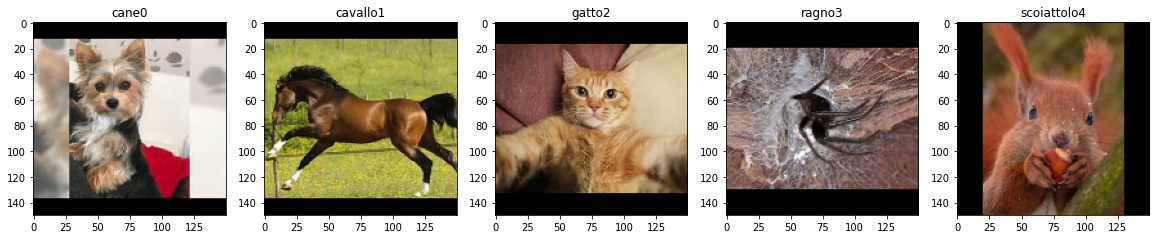

In [14]:
rows,cols = 1,5
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20,20))
for i in range(5):
    path = train_df[train_df.category == i].values[0]
    axes[i%cols].set_title(path[0].split('/')[-2] + str(path[1]))
    axes[i%cols].imshow(images[train_df[train_df.filename == path[0]].index[0]])

Convert data into numpy array

In [15]:
data_num = len(y)
random_index = np.random.permutation(data_num)

x_shuffle = []
y_shuffle = []
for i in range(data_num):
    x_shuffle.append(images[random_index[i]])
    y_shuffle.append(y[random_index[i]])
    
x = np.array(x_shuffle) 
y = np.array(y_shuffle)

#Split data into 80% training data and 20% validation data
val_split_num = int(round(0.2*len(y)))
x_train = x[val_split_num:]
y_train = y[val_split_num:]
x_test = x[:val_split_num]
y_test = y[:val_split_num]

print('x_train', x_train.shape)
print('y_train', y_train.shape)
print('x_test', x_test.shape)
print('y_test', y_test.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

#Change category name
img_rows, img_cols, img_channel = 150, 150, 3
name_animal = []
for i in range(5):
    path = train_df[train_df.category == i].values[0]
    if path[0].split('/')[-2] == 'cavallo':
        name_animal.append('horse')
    elif path[0].split('/')[-2] == 'gatto':
        name_animal.append('cat')
    elif path[0].split('/')[-2] == 'scoiattolo':
        name_animal.append('squirrel')
    elif path[0].split('/')[-2] == 'ragno':
        name_animal.append('spider')
    elif path[0].split('/')[-2] == 'cane':
        name_animal.append('dog')

x_train (8824, 150, 150, 3)
y_train (8824,)
x_test (2206, 150, 150, 3)
y_test (2206,)


In this project i use VGG16. VGG16 is a convolutional neural network model proposed by K. Simonyan and A. Zisserman from the University of Oxford in the paper “Very Deep Convolutional Networks for Large-Scale Image Recognition”.

In [16]:
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channel))

add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(166, activation='relu'))
add_model.add(Dense(5, activation='softmax'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_______________________________________________________

Train the model.

In [18]:
batch_size = 32
epochs = 20
checkpoint_path=f'/content/drive/My Drive/Dicoding/Belajar Pengembangan Machine Learning/testmodel_assignment3.h5'

# Initialize Callback for EarlyStopping
es = EarlyStopping(monitor='val_loss', patience=2, verbose=2) # training will stop if there is no improvement in val_accuracy in 3 epochs
mc = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')

train_datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True)
train_datagen.fit(x_train)


history = model.fit_generator(
    train_datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[es, mc]
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
275/275 [==============================] - 73s 264ms/step - loss: 0.4274 - accuracy: 0.4455 - val_loss: 0.2910 - val_accuracy: 0.6763
Epoch 2/20
275/275 [==============================] - 70s 253ms/step - loss: 0.2479 - accuracy: 0.7288 - val_loss: 0.1860 - val_accuracy: 0.8069
Epoch 3/20
275/275 [==============================] - 69s 252ms/step - loss: 0.1749 - accuracy: 0.8109 - val_loss: 0.1389 - val_accuracy: 0.8581
Epoch 4/20
275/275 [==============================] - 69s 252ms/step - loss: 0.1419 - accuracy: 0.8528 - val_loss: 0.1256 - val_accuracy: 0.8803
Epoch 5/20
275/275 [==============================] - 69s 251ms/step - loss: 0.1233 - accuracy: 0.8759 - val_loss: 0.1106 - val_accuracy: 0.8935
Epoch 6/20
275/275 [==============================] - 69s 252ms/step - loss: 0.1091 - accuracy: 0.8904 - val_loss: 0.1052 - val_accuracy: 0.8935
Epoch 7/20
275/275 [==============================] - 

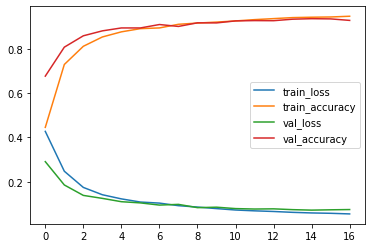

In [19]:
# Plot training history
pyplot.plot(history.history['loss'], label='train_loss')
pyplot.plot(history.history['accuracy'], label='train_accuracy')
pyplot.plot(history.history['val_loss'], label='val_loss')
pyplot.plot(history.history['val_accuracy'], label='val_accuracy')
pyplot.legend()
pyplot.show()

Test the model

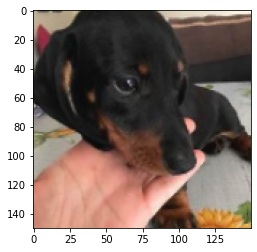

Actual  : dog
Predict : dog


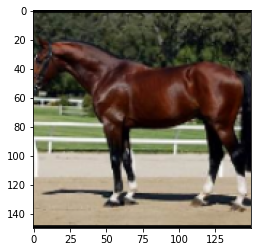

Actual  : horse
Predict : horse


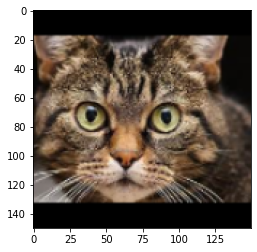

Actual  : cat
Predict : cat


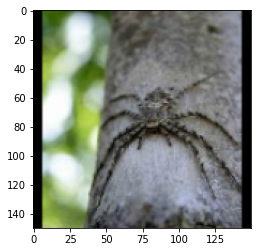

Actual  : spider
Predict : spider


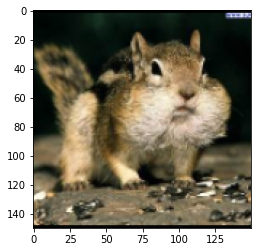

Actual  : squirrel
Predict : cat


In [20]:
test_images = []
j = 40 # change this to get different images
for i in range(5):
    path = train_df[train_df.category == i].values[j]
    a = images[train_df[train_df.filename == path[0]].index[0]]
    img = np.array(a)
    img = img[:, :, ::-1].copy() 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if(img.shape[0] > img.shape[1]):
        tile_size = (int(img.shape[1]*166/img.shape[0]),166)
    else:
        tile_size = (166, int(img.shape[0]*166/img.shape[1]))
    img = centering_image(cv2.resize(img, dsize=tile_size))
    img = img[8:158, 8:158]
    test_images.append(img)

test_images = np.array(test_images).reshape(-1,150,150,3)
something = model.predict(test_images)
animals = name_animal
i = 0
for pred in something:
    path = train_df[train_df.category == i].values[2]
    plt.imshow(test_images[i])
    plt.show()
    print('Actual  :', animals[i])
    print('Predict :', animals[np.where(pred.max() == pred)[0][0]])
    i += 1

Convert the model to tflite

In [38]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpenzau2p4/assets


INFO:tensorflow:Assets written to: /tmp/tmpenzau2p4/assets


In [39]:
cd /content/drive/My Drive/Dicoding/Belajar Pengembangan Machine Learning

/content/drive/My Drive/Dicoding/Belajar Pengembangan Machine Learning


Save the model

In [40]:
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)